In [1]:
%matplotlib inline


Region Growing Segmentation
===========================

Thresholding is the most basic form of segmentation. The first step of 
improvement upon the naive thresholding is a class of algorithms called 
region growing.

The common theme in this class of algorithms is that a voxel's
neighbor is considered to be in the same class if its intensities are
similar to the current voxel. The definition of similar is what varies.
Initial set of voxel are called seed points. These initial seed points are 
usually manually selected. 

We illustrate the use of three variants of this family of algorithms: 

- `ConnectedThreshold <http://www.itk.org/Doxygen/html/classitk_1_1ConnectedThresholdImageFilter.html>`_ 
- `ConfidenceConnected <http://www.itk.org/Doxygen/html/classitk_1_1ConfidenceConnectedImageFilter.html>`_ 
- `VectorConfidenceConnected <http://www.itk.org/Doxygen/html/classitk_1_1VectorConfidenceConnectedImageFilter.html>`_ 

We will illustrate the usage of these three filters using a cranial MRI
scan (T1 and T2) and attempt to segment one of the ventricles.



In [2]:
# License: CC-BY
# sphinx_gallery_thumbnail_number = 4
import sys

sys.path.append('/home/jmh/github/ITK/SimpleITK-Notebooks/Utilities')

import SimpleITK as sitk
from myshow import myshow, myshow3d
from downloaddata import fetch_data as fdata

Load Images
-----------



Fetching nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT1.nrrd


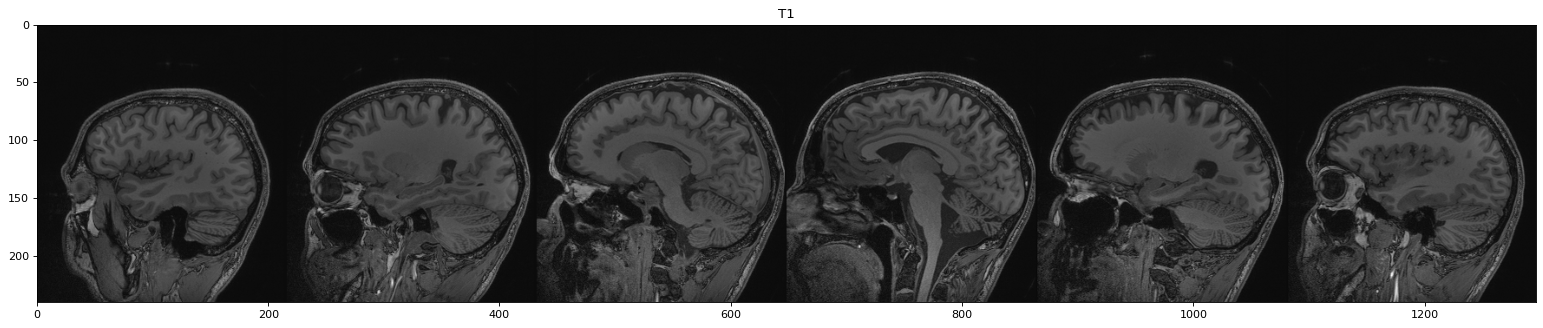

In [3]:
img_T1 = sitk.ReadImage(
    fdata("nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT1.nrrd"))

# To visualize the labels image in RGB needs a image with 0-255 range
img_T1_255 = sitk.Cast(sitk.RescaleIntensity(img_T1), sitk.sitkUInt8)

size = img_T1.GetSize()
myshow3d(img_T1_255, zslices=range(50, size[2] - 50, 20), title='T1')

Seed selection
--------------

Earlier we used 3D Slicer to determine that index: (132,142,96) was a
good seed for the left lateral ventricle.



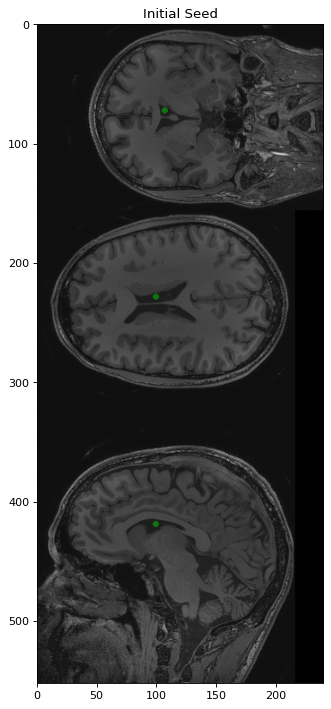

In [4]:
seed = (132, 142, 96)

seg = sitk.Image(img_T1.GetSize(), sitk.sitkUInt8)
seg.CopyInformation(img_T1)
seg[seed] = 1

seg = sitk.BinaryDilate(seg, 3)

myshow3d(sitk.LabelOverlay(img_T1_255, seg),
         xslices=range(132, 133), yslices=range(142, 143),
         zslices=range(96, 97), title="Initial Seed")

Region Growing
--------------
 Let's start with ``ConnectedThreshold``.

``ConnectedThreshold``
^^^^^^^^^^^^^^^^^^^^^^
Here, voxel’s neighbor is considered to be in the same class if the
neighboring voxel’s intensity is within explicitly specified thresholds.

We start by using explicitly specified thresholds, you should modify
these (lower/upper) to see the effects on the resulting segmentation.



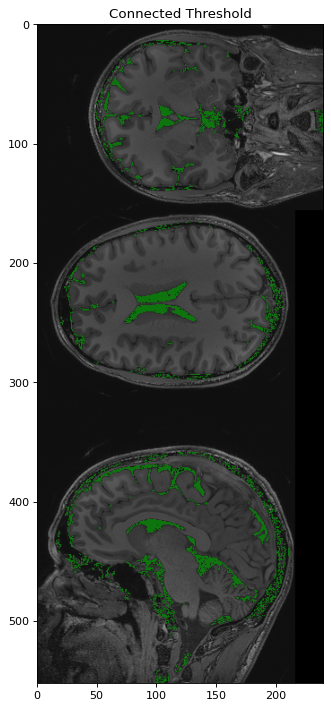

In [5]:
seg_con = sitk.ConnectedThreshold(img_T1, seedList=[seed],
                                  lower=100, upper=190)

myshow3d(sitk.LabelOverlay(img_T1_255, seg_con),
         xslices=range(132, 133), yslices=range(142, 143),
         zslices=range(96, 97), title="Connected Threshold")

``ConfidenceConnected``
^^^^^^^^^^^^^^^^^^^^^^^


Unlike in ``ConnectedThreshold``, you need not select the bounds in
``ConfidenceConnected`` filter. Bounds are implicitly specified as
$\mu\pm c\sigma$, where $\mu$ is the mean intensity of the seed
points, $\sigma$ their standard deviation and $c$ a user specified
constant.

This algorithm has some flexibility which you should familiarize yourself with:

* The ``multiplier`` parameter is the constant $c$ from the formula above.
* You can specify a region around each seed point ``initialNeighborhoodRadius``
  from which the statistics are estimated, see what happens when you set it to zero.
* The ``numberOfIterations`` allows you to rerun the algorithm. In the first
  run the bounds are defined by the seed voxels you specified, in the
  following iterations $\mu$ and $\sigma$ are estimated from
  the segmented points and the region growing is updated accordingly.



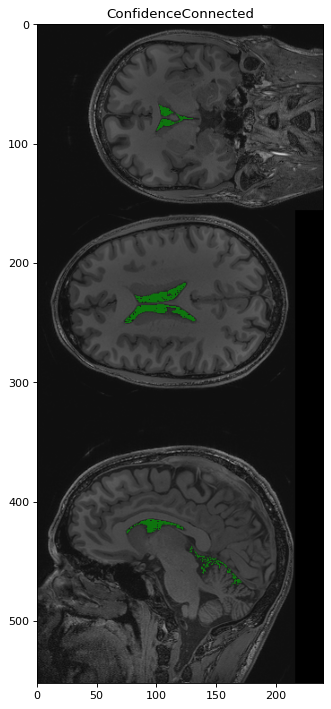

In [6]:
seg_conf = sitk.ConfidenceConnected(img_T1, seedList=[seed],
                                    numberOfIterations=1,
                                    multiplier=2.5,
                                    initialNeighborhoodRadius=1,
                                    replaceValue=1)

myshow3d(sitk.LabelOverlay(img_T1_255, seg_conf),
         xslices=range(132, 133), yslices=range(142, 143),
         zslices=range(96, 97), title="ConfidenceConnected")

``VectorConfidenceConnected``
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
A generalization of the previous approach to vector valued images,
for instance multi-spectral images or multi-parametric MRI.
Here, The bounds for neighboring voxel's intensity vector is 2implicitly
specified bounds using the Mahalanobis distance
$\sqrt{(\mathbf{x}-\mathbf{\mu})^T\Sigma^{-1}(\mathbf{x}-\mathbf{\mu})}<c$,
where $\mathbf{\mu}$ is the mean of the vectors at the seed points,
$\Sigma$ is the covariance matrix and $c$ is a user specified
constant.

Let's load a T2 image from the same person and combine it with the T1
image to create a vector image and apply the algorithm on it.



Fetching nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT2.nrrd


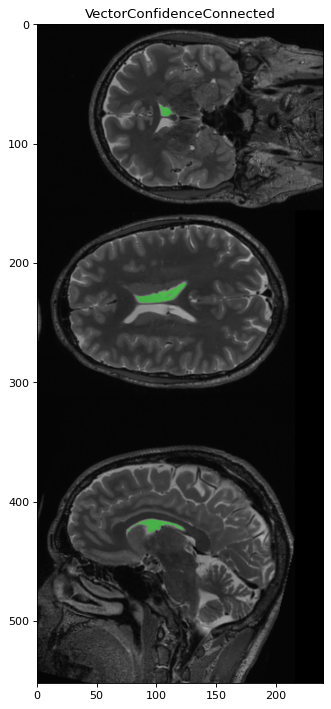

In [7]:
img_T2 = sitk.ReadImage(
    fdata("nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT2.nrrd"))
img_T2_255 = sitk.Cast(sitk.RescaleIntensity(img_T2), sitk.sitkUInt8)


img_multi = sitk.Compose(img_T1, img_T2)
seg_vec = sitk.VectorConfidenceConnected(img_multi, seedList=[seed],
                                         numberOfIterations=1,
                                         multiplier=4,
                                         initialNeighborhoodRadius=1)

myshow3d(sitk.LabelOverlay(img_T2_255, seg_vec),
         xslices=range(132, 133), yslices=range(142, 143),
         zslices=range(96, 97), title="VectorConfidenceConnected")

Clean up, clean up
------------------

Use of low level segmentation algorithms such as region growing is often followed by a clean up step. In this step we fill holes and remove small connected components. Both of these operations are achieved by using binary morphological operations, opening (``BinaryMorphologicalOpening``) to remove small connected components and closing (``BinaryMorphologicalClosing``) to fill holes.

SimpleITK supports several shapes for the structuring elements (kernels) including:

- sitkAnnulus
- sitkBall
- sitkBox
- sitkCross

The size of the kernel can be specified as a scalar (same for all dimensions) or as a vector of values, size per dimension.

The following code illustrates the results of such a clean up, using
closing to remove holes in the original segmentation.



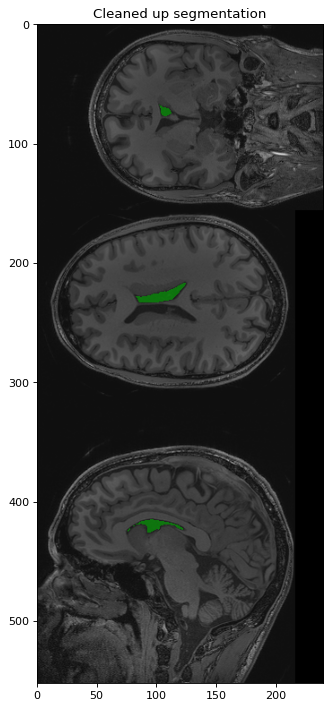

In [8]:
vectorRadius = (1, 1, 1)
kernel = sitk.sitkBall
seg_clean = sitk.BinaryMorphologicalClosing(seg_vec,
                                            vectorRadius,
                                            kernel)

myshow3d(sitk.LabelOverlay(img_T1_255, seg_clean),
         xslices=range(132, 133), yslices=range(142, 143),
         zslices=range(96, 97), title="Cleaned up segmentation")